# Order Predictions by Day

### Table of Contents

* [Reformatting By Day](#byday)
    * [Train-Test Split by Day](#trainday)
* Forecasting Algorithms
    * [Auto_Arima](#arima)
        * [By Day](#aday)    
    * [Exponential Smoothing](#exp)
        * [By Day](#expd)
    * [SARIMAX](#sar)
        * [By Day](#sard)
* [Forecasting Algorithm Comparison](#comp)

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import json
import matplotlib.pyplot as plt
#from pmdarima.arima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.statespace.sarimax import SARIMAX

Below we decided to focus on orders placed within California so we merged employee information to then filter down to CA placed orders

In [ ]:
orders = pd.read_csv('true.csv', header=None, quotechar="'")
orders = orders.rename(columns={0: "order_id", 1: "owner_name", 2:"is_developer", 3:"time_created", 4:"items"})
orders.head()

In [3]:
len(orders)

44942

In [4]:
employees = pd.read_csv('employee.csv')
employees = employees[['WORK_EMAIL', 'LOCATION']]

In [ ]:
employees['owner_name'] = employees['WORK_EMAIL'].str.split('@').str[0]
employees.head()

In [6]:
orders = orders.merge(employees, how='inner', on='owner_name')

In [8]:
len(orders)

43642

In [ ]:
ca = orders[orders['LOCATION'].str.contains('CA', regex=False)]
ca.head()

In [10]:
len(ca)

26320

In [11]:
orders = ca.reset_index()

## By Day <a class="anchor" id="byday"></a>

Since we are attempting to predict the number of orders placed on a day, I converted the timestamp into a datetime to be later grouped.

In [12]:
dates = []
for i in orders['time_created']:
    date = dt.datetime.fromtimestamp(i).strftime('%Y-%m-%d')
    dates.append(date)

In [13]:
orders['date'] = dates

In [20]:
order_item_types = [[item['type'] for item in json.loads(row).values()] for row in orders['items']]

We aimed to have mutliple prediction algorithms for different item types, so we first focused on a order with an item of 'cdm_cluster'

In [17]:
items = []
for i in range(len(orders)):
    items.append([])
for i in np.arange(len(orders)):
    item_dict = json.loads(orders['items'][i])
    for nickname, item in item_dict.items():
        item_type = item['type']
        items[i].append(item_type)
orders['item_type'] = items

In [ ]:
booly = []
for i in order_item_types:
    if 'cdm_cluster' in i:
        booly.append(True)
    else:
        booly.append(False)
cdm_clust = orders[booly]
cdm_clust.head()

In [16]:
grouped = cdm_clust.groupby('date').size().to_frame().sort_values(by='date')
grouped = grouped.rename(columns={0: "count"})
grouped = grouped.reset_index()
grouped.head()

,date,count
0,2020-05-15,11
1,2020-05-16,5
2,2020-05-17,4
3,2020-05-18,17
4,2020-05-19,23


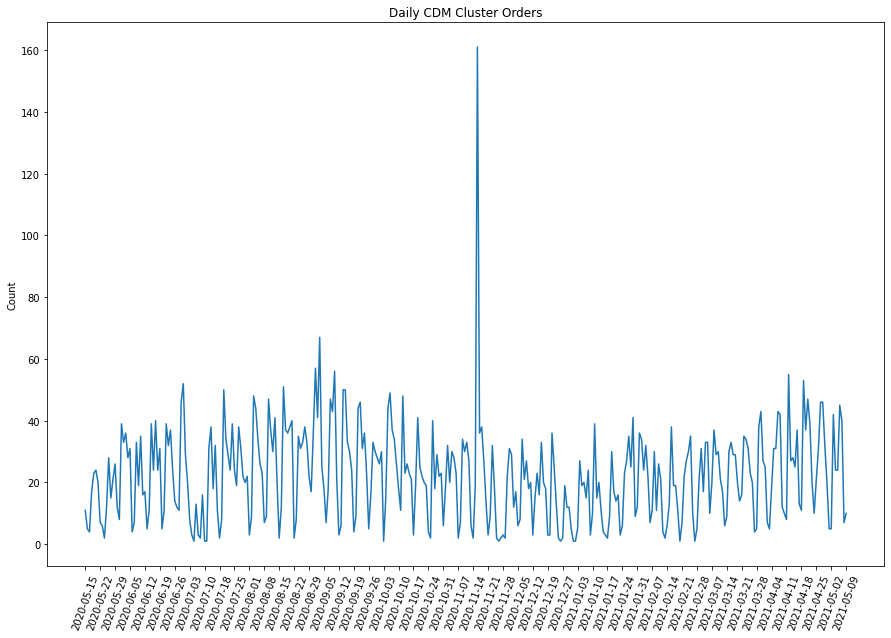

In [17]:
plt.figure(figsize=(15, 10))

plt.title('Daily CDM Cluster Orders')
plt.ylabel('Count')
plt.plot(grouped['date'], grouped['count'])
plt.xticks(rotation=70)
plt.xticks(grouped["date"][::7]);

In [ ]:
grouped['date_temp'] = grouped.date.str[:10]
grouped.head()

We also decided to focus on orders placed during the workweek, as most orders come from this time period and would be more easily able to predict.

In [19]:
datetimes = []
for i in grouped['date_temp']:
    date = dt.datetime.strptime(i, '%Y-%m-%d')
    datetimes.append(date.weekday())
grouped['weekday'] = datetimes
grouped.head()

,date,count,date_temp,weekday
0,2020-05-15,11,2020-05-15,4
1,2020-05-16,5,2020-05-16,5
2,2020-05-17,4,2020-05-17,6
3,2020-05-18,17,2020-05-18,0
4,2020-05-19,23,2020-05-19,1


In [20]:
weekdays = grouped[(grouped['weekday']!=5) & (grouped['weekday']!=6)]
weekdays = weekdays[['date', 'count']]
weekdays = weekdays.sort_values(by='date')
weekdays.head()

,date,count
0,2020-05-15,11
3,2020-05-18,17
4,2020-05-19,23
5,2020-05-20,24
6,2020-05-21,20


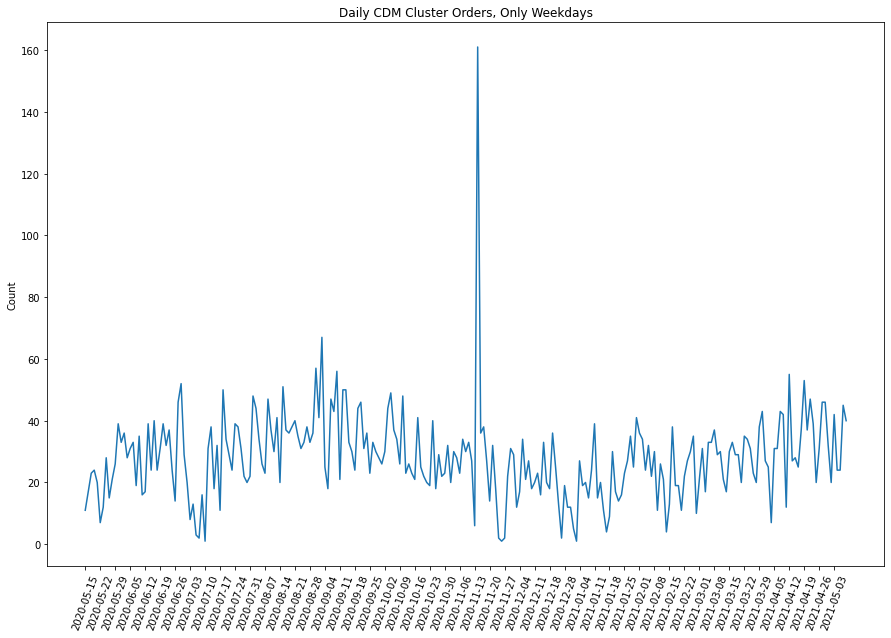

In [21]:
plt.figure(figsize=(15, 10))

plt.title('Daily CDM Cluster Orders, Only Weekdays')
plt.ylabel('Count')
plt.plot(weekdays['date'], weekdays['count'])
plt.xticks(rotation=70)
plt.xticks(weekdays["date"][::5]);

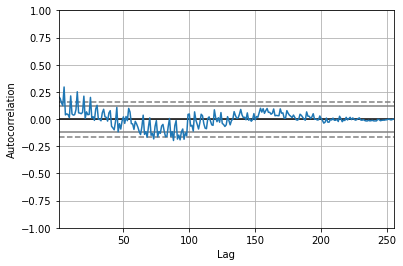

In [22]:
pd.plotting.autocorrelation_plot(weekdays['count']);

## For Testing Daily <a class="anchor" id="trainday"></a>

In [23]:
grouped = grouped[['date', 'count']]
grouped.head()

,date,count
0,2020-05-15,11
1,2020-05-16,5
2,2020-05-17,4
3,2020-05-18,17
4,2020-05-19,23


In [24]:
test = grouped.tail(30)
test.head()

,date,count
328,2021-04-10,10
329,2021-04-11,8
330,2021-04-12,55
331,2021-04-13,27
332,2021-04-14,28


In [25]:
train = grouped[grouped['date']<list(test['date'])[0]]
train = train.tail(104)
train.tail()

,date,count
323,2021-04-05,31
324,2021-04-06,31
325,2021-04-07,43
326,2021-04-08,42
327,2021-04-09,12


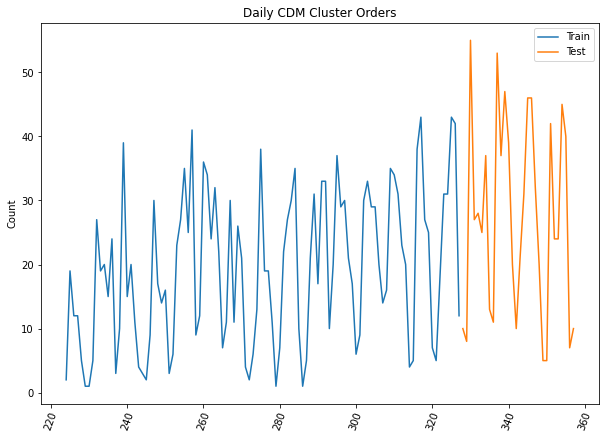

In [26]:
plt.figure(figsize=(10,7))
plt.title('Daily CDM Cluster Orders')
plt.ylabel('Count')
plt.plot(train['count'], label='Train')
plt.plot(test['count'], label='Test')
plt.xticks(rotation=70)
plt.legend();

In [27]:
all_mses = []

In [28]:
all_mape = []

## Auto_Arima <a class="anchor" id="arima"></a>

### Auto_ARIMA By Day <a class="anchor" id="aday"></a>

In [29]:
def get_mape(actuals, forecasts):
    MAPE = ((actuals-forecasts).abs().div(actuals).mean())
    return MAPE

In [30]:
model = auto_arima(train['count'], trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=820.675, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=820.687, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=818.681, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.953 seconds


In [31]:
model.fit(train['count'])

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [32]:
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

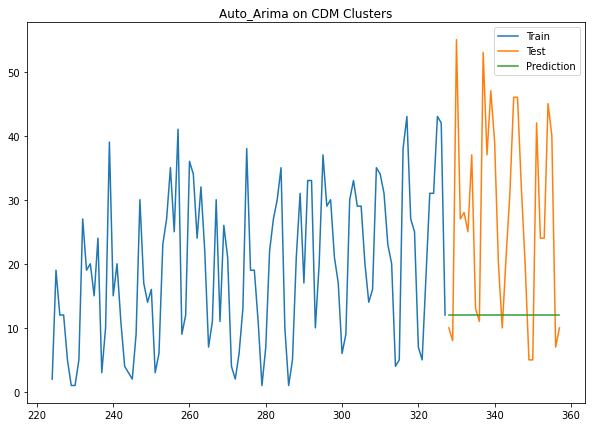

In [33]:
plt.figure(figsize=(10, 7))
plt.plot(train['count'], label='Train')
plt.plot(test['count'], label='Test')
plt.plot(forecast, label='Prediction')
plt.title('Auto_Arima on CDM Clusters')
plt.legend();

In [34]:
arima_mape = get_mape(test['count'], forecast['Prediction'])
all_mape.append(arima_mape)
arima_mape

0.5955066520955195

In [35]:
arima_mse = mse(test['count'], forecast['Prediction'])
all_mses.append(arima_mse)
arima_mse

462.6666666666667

## Exponential Smoothing <a class="anchor" id="exp"></a>

### Exponential Smooting by Day <a class="anchor" id="expd"></a>

In [36]:
## Try different parameters

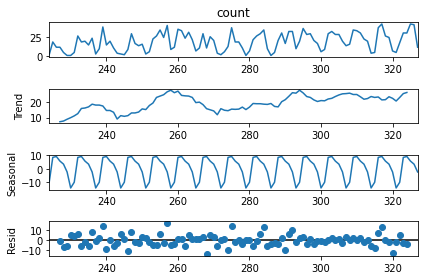

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_result = seasonal_decompose(train['count'], period=7)
decompose_result.plot();

### On all the training data

In [38]:
train['predicted'] = ExponentialSmoothing(train['count'],trend='add',seasonal='add', seasonal_periods=7).fit().fittedvalues

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


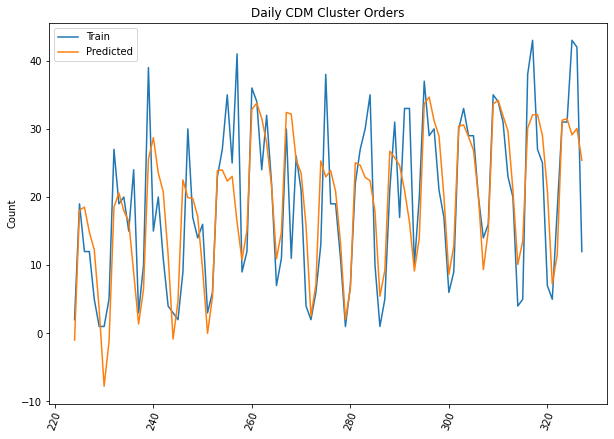

In [39]:
plt.figure(figsize=(10,7))
plt.title('Daily CDM Cluster Orders')
plt.ylabel('Count')
plt.plot(train['count'], label='Train')
plt.plot(train['predicted'], label='Predicted')
plt.xticks(rotation=70)
plt.legend();

In [40]:
get_mape(train['count'], train['predicted'])

0.5869495903713705

In [41]:
mse(train['count'], train['predicted'])

53.90916392267222

### Test on Exponential Smoothing

In [42]:
## Play with parameters

In [43]:
train = train.set_index('date')
test = test.set_index('date')

In [44]:
model = ExponentialSmoothing(train['count'], trend=None, seasonal='add', seasonal_periods=7).fit(optimized = True)

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [45]:
test['predicted'] = list(model.forecast(30))

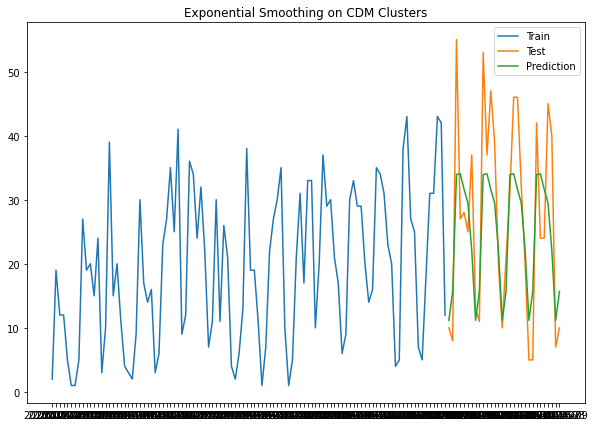

In [46]:
plt.figure(figsize=(10, 7))
plt.plot(train['count'], label='Train')
plt.plot(test['count'], label='Test')
plt.plot(test['predicted'], label='Prediction')
plt.title('Exponential Smoothing on CDM Clusters')
plt.legend();

In [47]:
exp_mape = get_mape(test['count'], test['predicted'])
all_mape.append(exp_mape)
exp_mape

0.38639825144616063

In [48]:
exp_mse = mse(test['count'], test['predicted'])
all_mses.append(exp_mse)
exp_mse

97.48335724621509

## SARIMA <a class="anchor" id="sar"></a>

### SARIMAX by Day <a class="anchor" id="sard"></a>

In [49]:
## Make stationary

In [50]:
# mses = []
# values = []
# for i in range(0,4):
#     for j in range(0,4):
#         for k in range(0,4):
#             model_sarimax = SARIMAX(train['count'],  order=(i,j,k), seasonal_order=(1,1,1,7), suppress_warnings=True) 
#             model_sarimax_fit = model_sarimax.fit()
#             pred = list(model_sarimax_fit.forecast(30))
#             mse_1 = mse(test['count'], pred)
#             mses.append(mse_1)
#             values.append([i,j,k])

In [51]:
# values[mses.index(min(mses))]

In [52]:
# [0, 1, 3]

In [53]:
model_sarimax = SARIMAX(train['count'],  order=(0,1,3), seasonal_order=(1,1,1,7)) 
model_sarimax_fit = model_sarimax.fit()
test['pred'] = list(model_sarimax_fit.forecast(30))

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


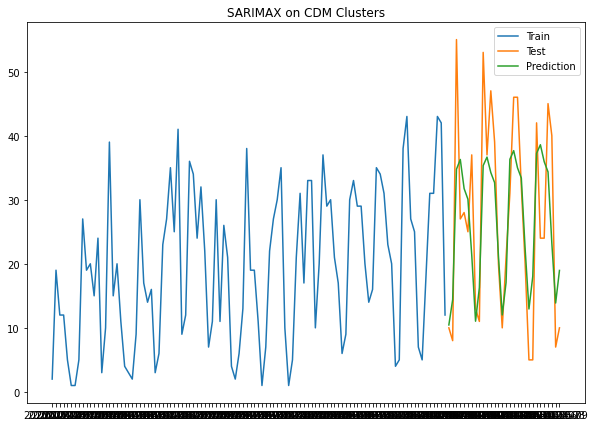

In [54]:
plt.figure(figsize=(10, 7))
plt.plot(train['count'], label='Train')
plt.plot(test['count'], label='Test')
plt.plot(test['pred'], label='Prediction')
plt.title('SARIMAX on CDM Clusters')
plt.legend();

In [55]:
sar_mape = get_mape(test['count'], test['pred'])
all_mape.append(sar_mape)
sar_mape

0.42900218520688577

In [56]:
sar_mse = mse(test['count'], test['pred'])
all_mses.append(sar_mse)
sar_mse

91.59893277805085

## Comparing Models <a class="anchor" id="comp"></a>

In [57]:
d = {'Model':['ARIMA', 'Exponential Smoothing', 'SARIMAX'], 'MSE': all_mses, 'MAPE' : all_mape}
comp = pd.DataFrame(data=d)
comp

,Model,MSE,MAPE
0,ARIMA,462.666667,0.595507
1,Exponential Smoothing,97.483357,0.386398
2,SARIMAX,91.598933,0.429002
